# Multivariate ITS model for a saturated market

This notebook focusses on the use of the Multivariate Interrupted Time Series (MVITS) model to estimate where new product sales come from. If you have not yet done so, we recommend that you read our [Introduction to product incrementality](../../guide/incrementality/incrementality_intro.md) guide as well as the [Multivariate interrupted time series model](../../guide/incrementality/mv_its_intro.md) guide before continuing.

We will walk through a number of scenarios, from simple to complex, to show how the MVITS model can be used to estimate the impact of a new product on existing products.

## Notebook setup

In [1]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pymc_marketing.product_incrementality.mv_its import MVITS

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format = 'retina'
az.style.use("default")
plt.rcParams["figure.figsize"] = [10, 5]
rng = np.random.default_rng(42)

## Synthetic data generation

We will generate synthetic data according to the following causal model. This is intentionally simple in this introduction to the MVITS model and it likely not going to capture the complexities of real-world data.

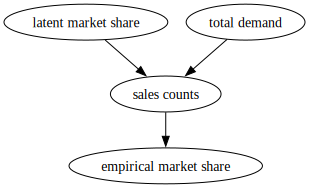

In [4]:
g = gr.Digraph()
g.node(name="share", label="latent market share")
g.node(name="total_demand", label="total demand")
g.node(name="sales_counts", label="sales counts")
g.node(name="empirical_share", label="empirical market share")

g.edge(tail_name="share", head_name="sales_counts")
g.edge(tail_name="total_demand", head_name="sales_counts")
g.edge(tail_name="sales_counts", head_name="empirical_share")
# Render
g

* We assume that there is a latent (unobserved) market share which equates to the popularity of different broducts or brands.
* We assume that there is a level of demand which is broadly stable, but is noisy. Some times more product is sold than other times.
* The empirically observed sales counts are causally influenced by both the latent market share and the total demand. This relationship could be modelled in different ways, but here we assume $\text{sales counts} \sim \mathrm{Multinomial}(\text{total demand}, \text{latent market share})$.

```{admonition} Empirical market share
:class: note

Based off of the observed sales counts, we could calculate empirical market shares. This does not play an important role in our data generation process, but it is important to highlight the difference between noisy empirical observed market shares versus the latent market shares which represent some form of underlying popularity of products or brands.

If we wanted to calculate empirical market share, this would simply be a case of dividing the observed sales (for each product/brand) by the total observed sales.

Readers could do that with the following code:

```python
# generate simulated data
data = generate_data(total_sales_mu=1000, total_sales_sigma=10, treatment_time=20, n_observations=60)

# calculate empirical market share
empirical_market_share = pd.DataFrame.from_dict(
    {"competitor": data["competitor"] / data[["competitor", "own"]].sum(axis=1),
    "own": data["own"] / data[["competitor", "own"]].sum(axis=1)})


fig, ax = plt.subplots(1, 2)

MVITS.plot_data(data, ax[0])
ax[0].set(title="Empirically observed sales counts")

empirical_market_share.plot(ax=ax[1])
ax[1].set(title="Empirical estimates of underlying latent market share");
```

We can generate synthetic data from this causal model like this:

In [5]:
def generate_data(
    total_sales_mu: int,
    total_sales_sigma: float,
    treatment_time: int,
    n_observations: int,
):
    market_shares_before = [[0.6, 0.4, 0]]
    market_shares_after = [[0.55, 0.35, 0.1]]

    # Determine latent market shares
    rates = np.array(
        treatment_time * market_shares_before
        + (n_observations - treatment_time) * market_shares_after
    )

    # Generate total demand (sales) as normally distributed around some average level of sales
    total = (
        rng.normal(loc=total_sales_mu, scale=total_sales_sigma, size=n_observations)
    ).astype(int)

    # Ensure total sales are never negative
    total[total < 0] = 0

    # Generate sales counts
    counts = rng.multinomial(total, rates)

    # Convert to DataFrame
    data = pd.DataFrame(counts)
    data.columns = ["competitor", "own", "new"]
    data.columns.name = "product"
    data.index.name = "day"
    data["pre"] = data.index < treatment_time
    return data

## Scenario 1

The first scenario we will examine is the simplest. 

* Our company has launched a new product
* We have sales data covering before and after this product launch
* Regardless of whether we have product level sales data or not, we focus purely on whether the sales of the new product are incremental (taking sales from competitors) or cannibalistic (taking sales from your existing products). As such we operate on data aggregated into "your company total sales" and "all competitor total sales".
* To keep the example simple we have stable market shares which only shift at the point of introducing the new product.
* Complexities such as seasonality in total demand, product pricing or other attributes are ignored and do not feature in this model.

In [6]:
scenario1 = {
    "total_sales_mu": 1000,
    "total_sales_sigma": 5,
    "treatment_time": 40,
    "n_observations": 100,
}

data = generate_data(**scenario1)
data.head()

product,competitor,own,new,pre
day,,,,
0,619,382,0,True
1,587,407,0,True
2,587,416,0,True
3,581,423,0,True
4,594,396,0,True


As always, we must visualise the data! We can see noisy but broadly flat sales of your own and all competitor products. Then you launch a new product which sells quite well. Visually we get a sense that the sales of your own and competitor sales drop, but can we put numbers on how incremental or cannabalistic the new product is? That will be the goal of our analysis.

Note: In this example we assume we have a saturated market, so sales of the new product necessarily take sales away from other products.

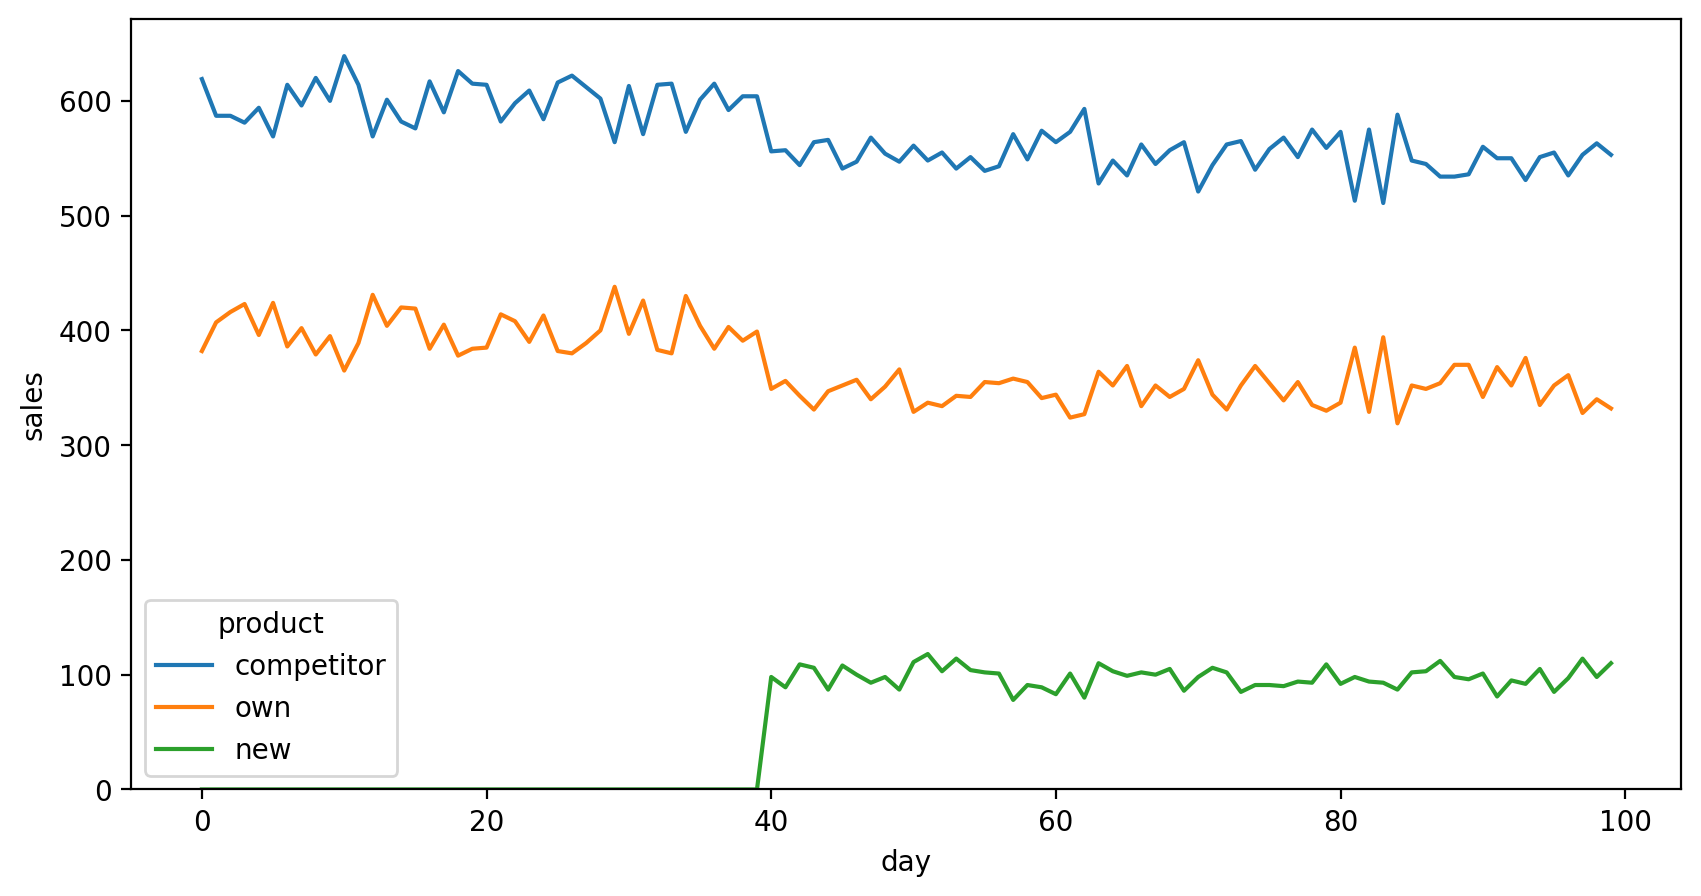

In [7]:
ax = MVITS.plot_data(data)
ax.set(ylabel="sales");

Let's take a look at the relationship between the new product sales and both the own and competitor sales. We can see negative correlations, and this makes sense from the MVITS modeling perspective. This is because it models sales of existing products as being _decreased_ by some fraction of the new product sales. So the model assumes that (in the post product launch period) that as the new product sales increase, the sales of the own or competitor will either decrease or remain unchanged. 

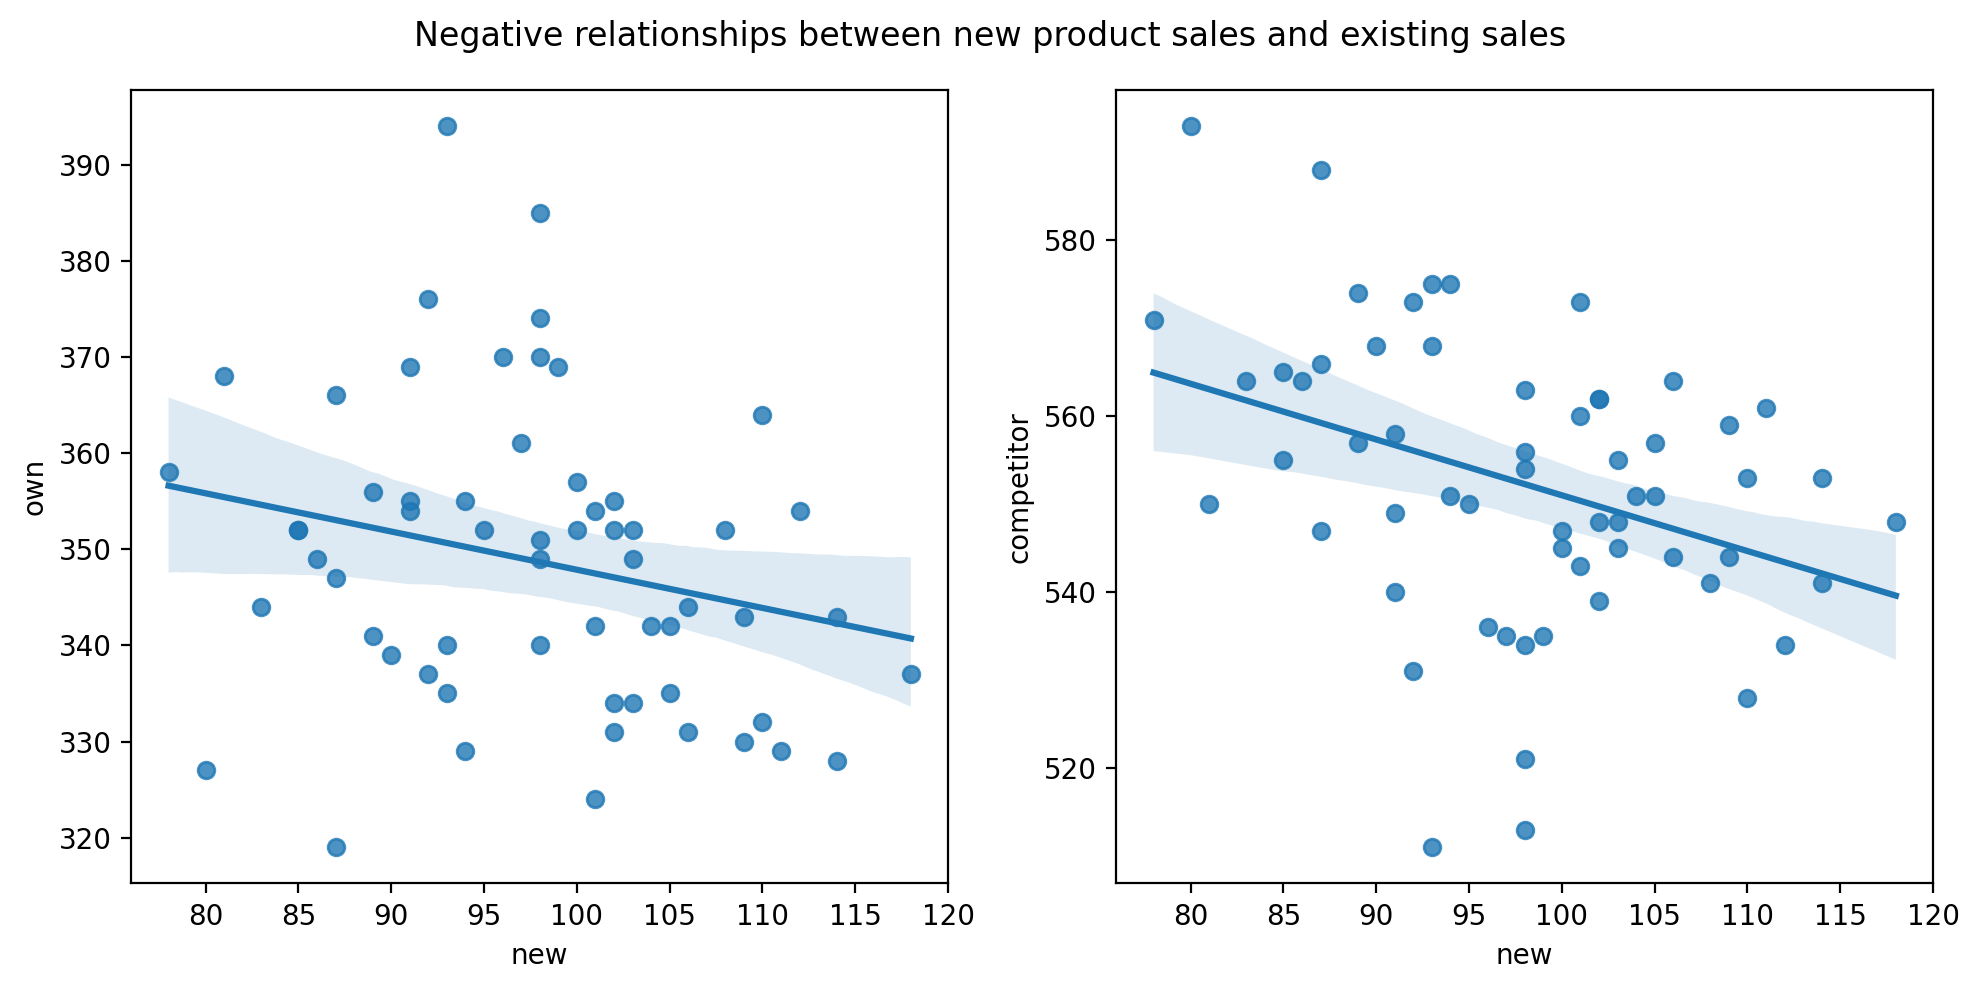

In [8]:
fig, ax = plt.subplots(1, 2)
sns.regplot(data=data.query("pre == False"), x="new", y="own", ax=ax[0])
sns.regplot(data=data.query("pre == False"), x="new", y="competitor", ax=ax[1])
plt.suptitle("Negative relationships between new product sales and existing sales")
plt.tight_layout()

### Model building and fitting

In [9]:
result = MVITS(
    data,
    treatment_time=scenario1["treatment_time"],
    background_sales=["competitor", "own"],
    innovation_sales="new",
    rng=rng,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, background_product_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y]


Output()

Sampling: [y]


Output()

### Model diagnostics

Let's check the traces of the parameters to see if they are stationary, and to see if the posteriors are well mixed.

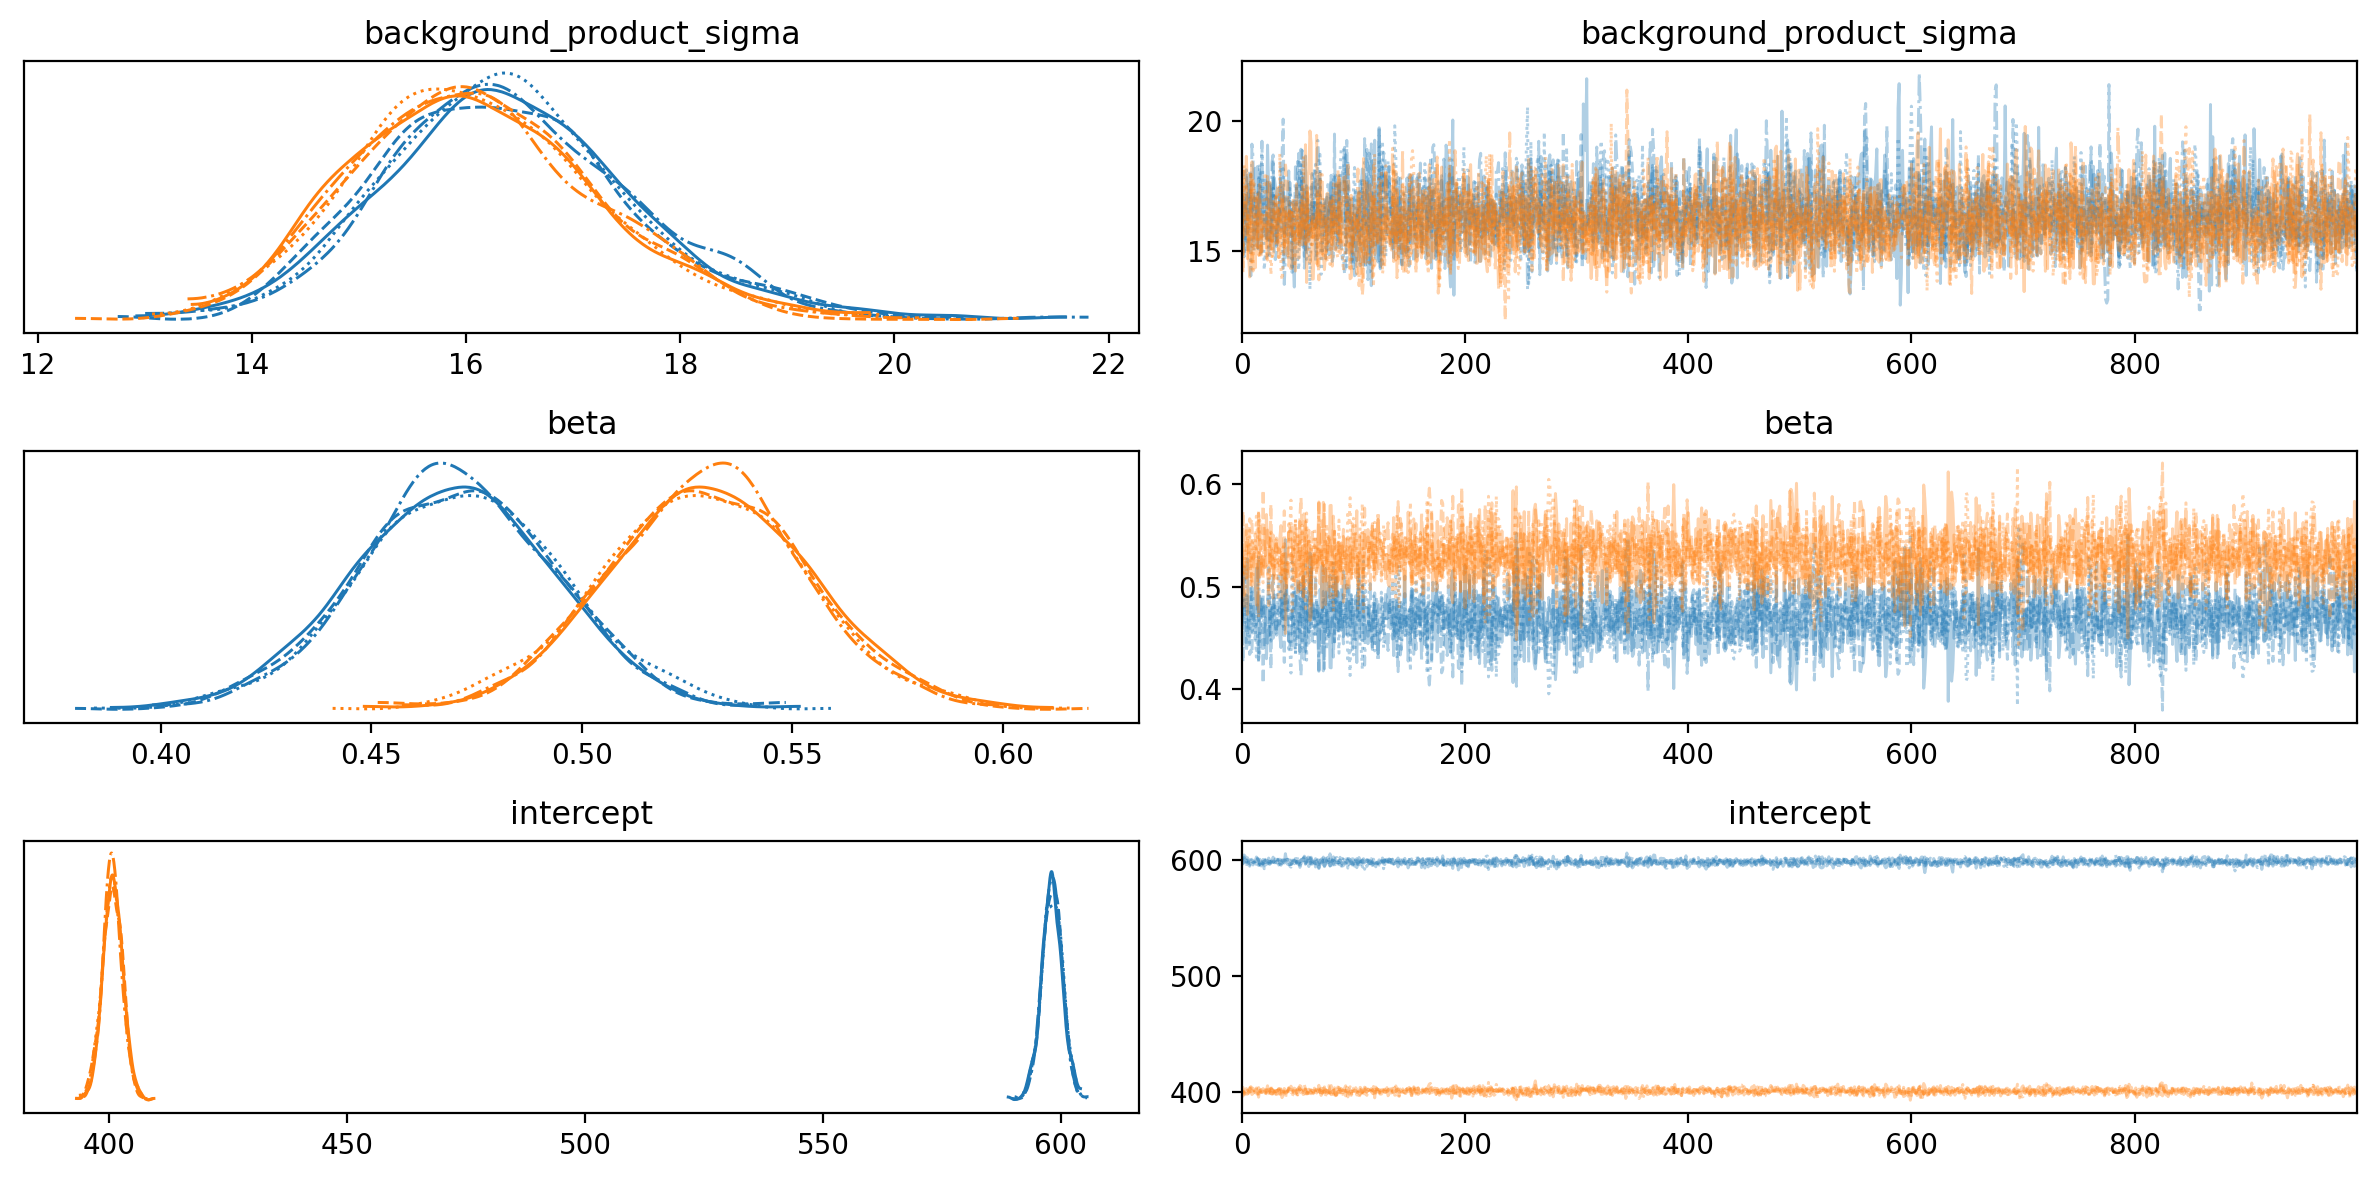

In [10]:
az.plot_trace(result.idata, var_names="~mu")
plt.tight_layout()

### Model results

Let's (visually) evaluate to what extent the model can account for the sales data by plotting posterior predictive fits. The plot below looks pretty good - we can see that the model predictions (shaded regions) capture the main properties of the actual sales data, namely the step change at the time of the new product introduction.

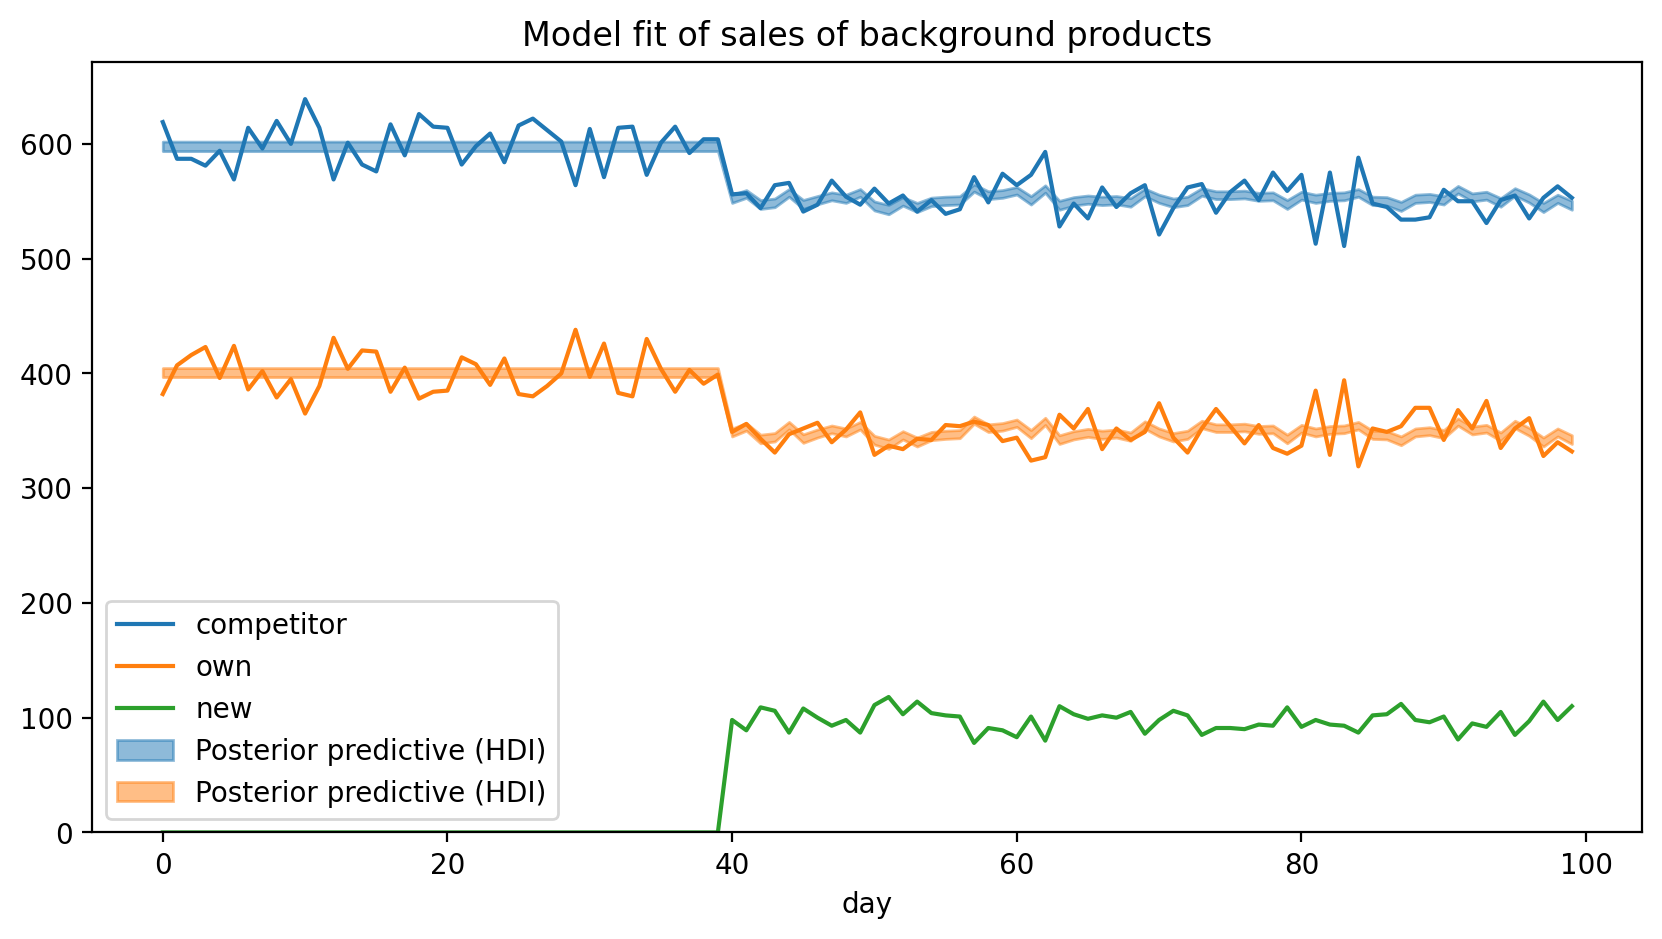

In [11]:
result.plot_fit();

Now let's look at the model's predicted sales in the counterfactual scenario where the company did not launch the new product. We can evaluate this visually to see if the counterfactual scenario 'makes sense'. In this ultra-simplified example it is easy to evaluate this as a "yes". The model predicts what we would intuitively expect, that the own and competitor sales would have continued as they were prior to the new product launch.

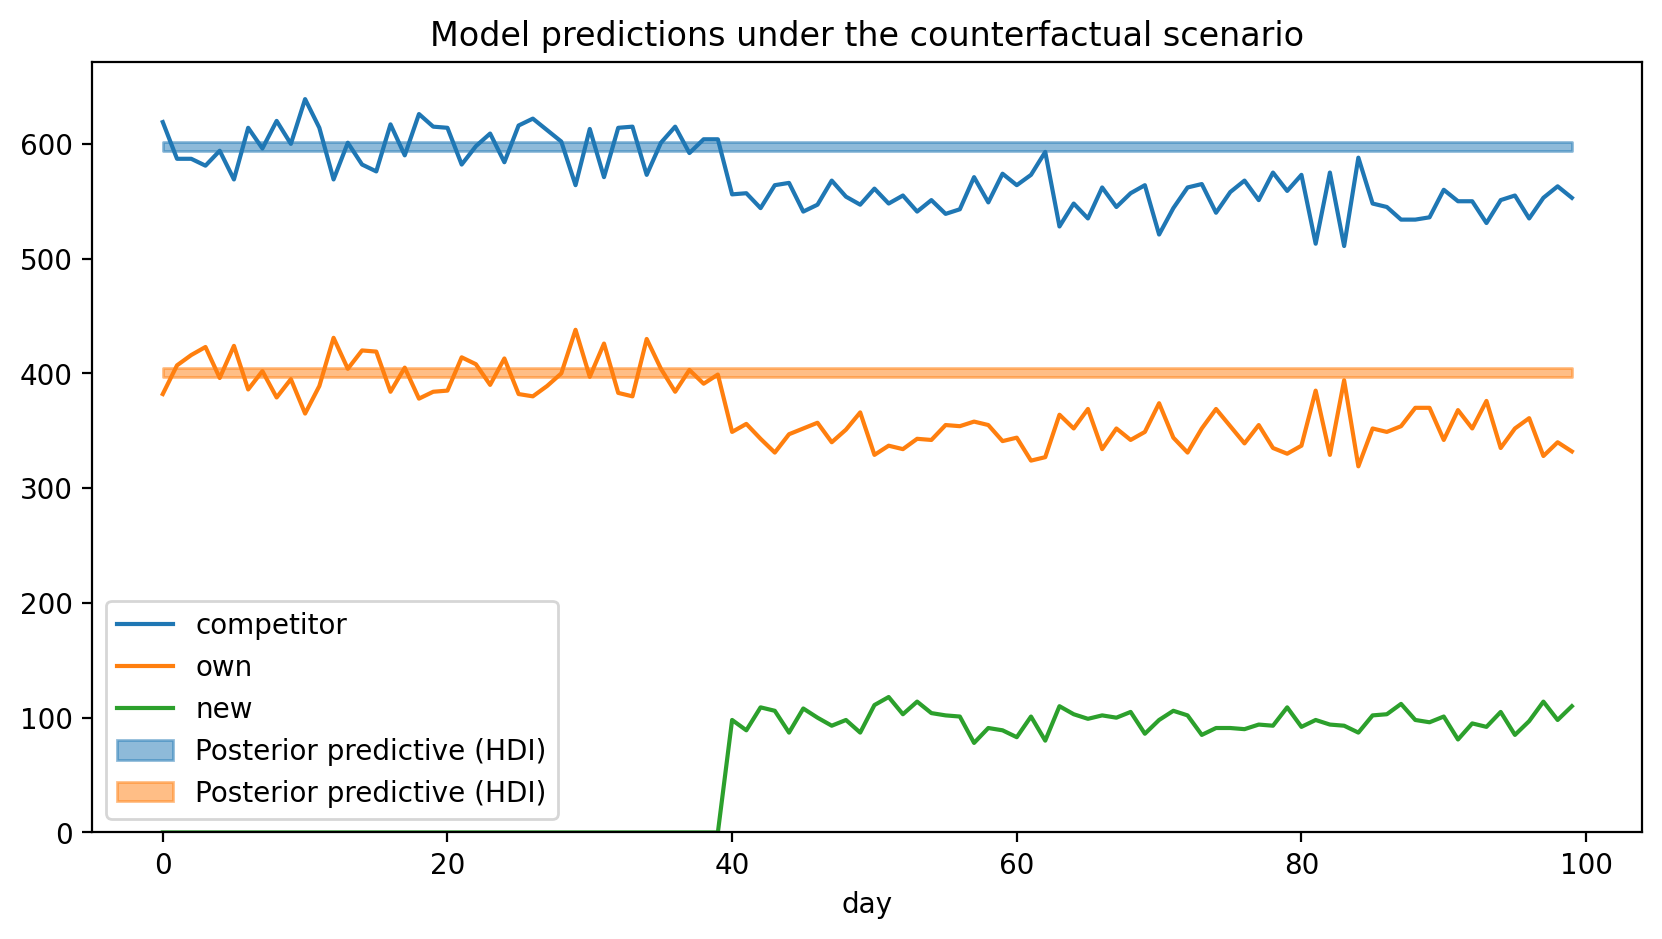

In [12]:
result.plot_counterfactual()

```{admonition} Counterfactual scenario of not releasing the new product
:class: note

The counterfactual scenario is evaluated by setting the sales of the new product (using PyMC's `do` operator) to zero in the model's input data. We then run posterior predictive sampling to see how the expected sales, and actual sales counts are affected by this intervention in the causal graph.

By comparing the two (the model predictions in the _actual_ and the _counterfactual_ scenarios), we have our estimated causal impacts upon each of the existing products of the new product launch. Here we can see that both own and competitor sales were reduced by the launch of the new product sales. So the model is attributing the sales of the new product as having come from both own and competitor sales in (approximately) equal amounts. Another way of saying this is that we have approximately 50% innovation and 50% cannibalisation.

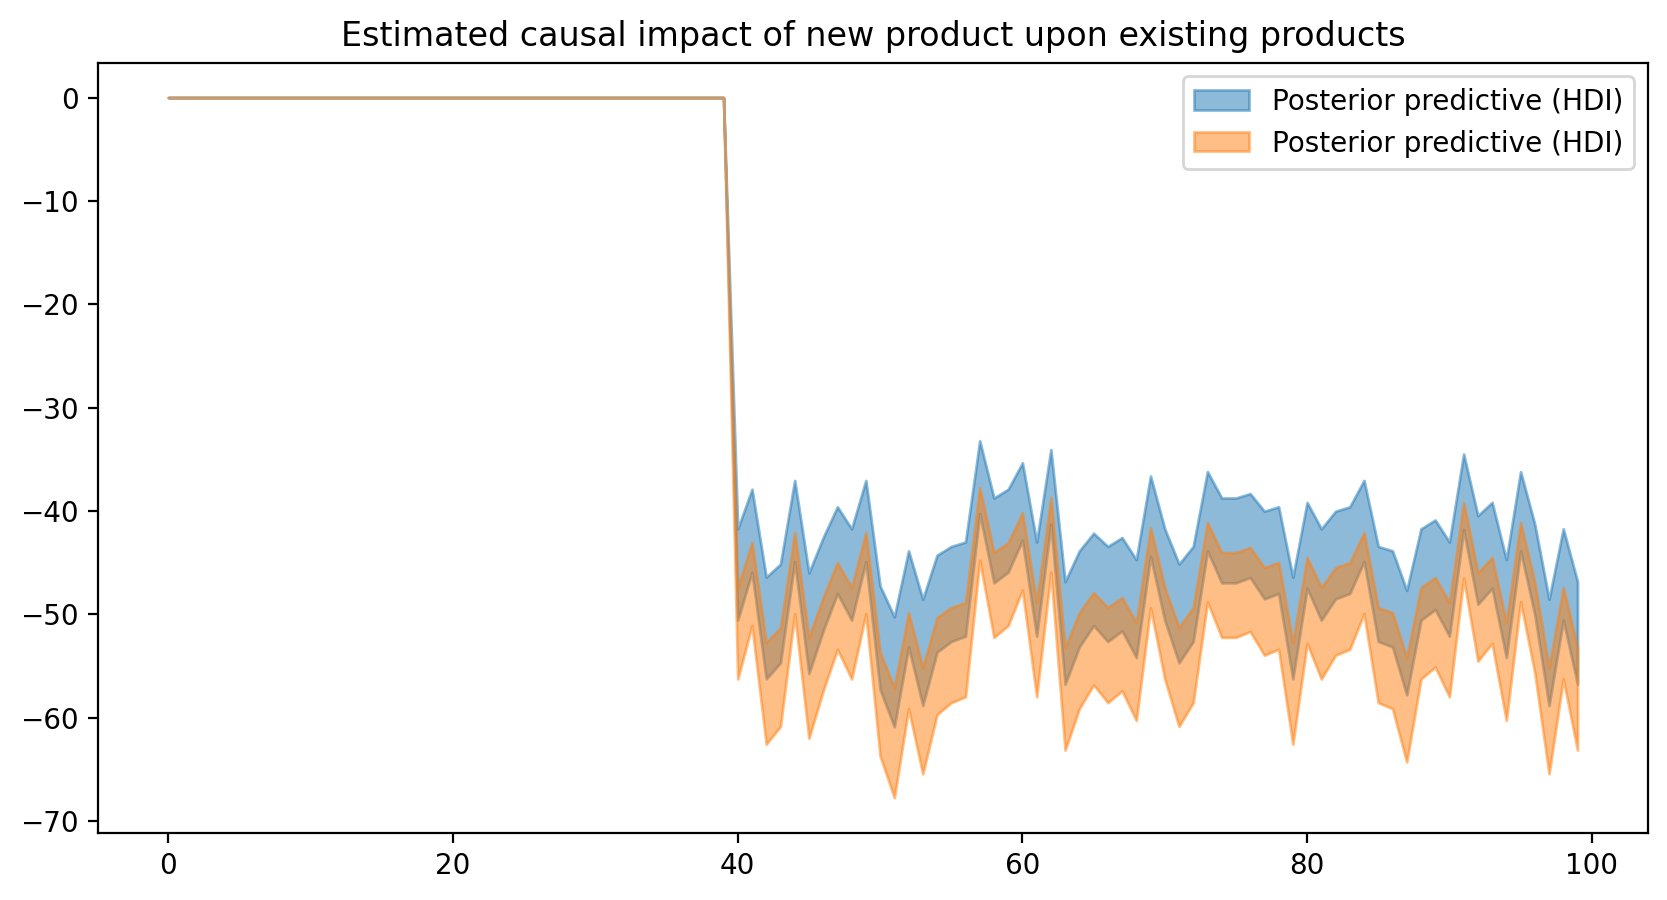

In [13]:
result.plot_causal_impact()

However we can see that it is not exactly 50/50. In order to get a more precise measure of the relative innovation or cannibalization, we can take a look at the $\beta$ parameters. 

* The `beta[competitor]` coefficient represents the proportion of sales of the new product which came from competitor sales. So this represents the % incrementality.
* The `beta[own]` coefficient represents the proportion of sales of the new product which came from your own sales. So this represents the % cannibalization.

We can see that the 94% credible intervals are relatively broad, so practically we may conclude that we have approximately 50% incrementality, with a slight hint that it may be slightly less than this.

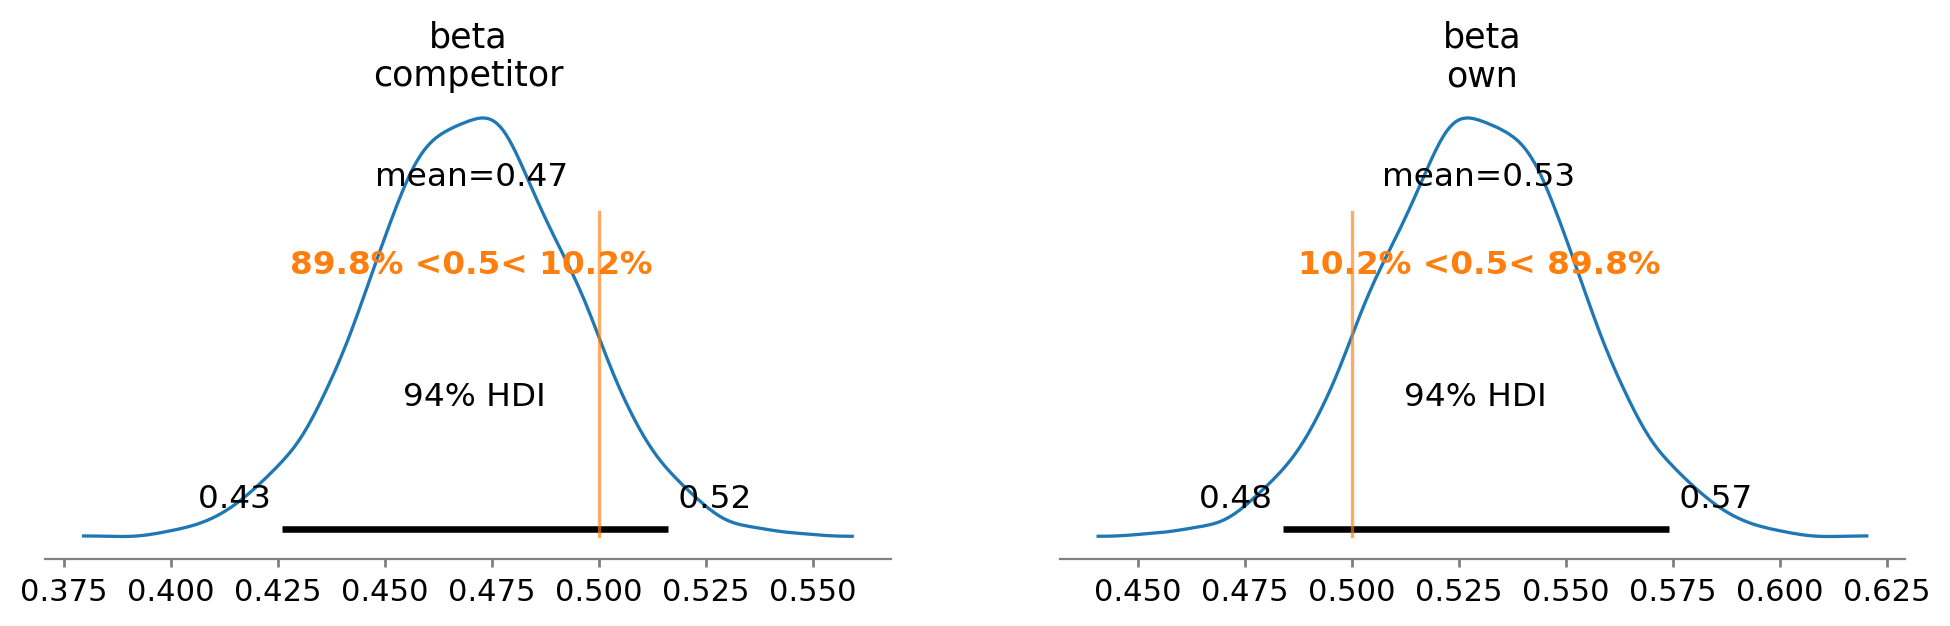

In [14]:
az.plot_posterior(
    result.idata, var_names=["beta"], ref_val=0.5, textsize=11, figsize=(12, 3)
);

## Scenario 2

This scenario is exactly the same to the previous, except for the having much greater variability in total sales figures.

In [15]:
scenario2 = {
    "total_sales_mu": 1000,
    "total_sales_sigma": 80,
    "treatment_time": 40,
    "n_observations": 100,
}

data = generate_data(**scenario2)

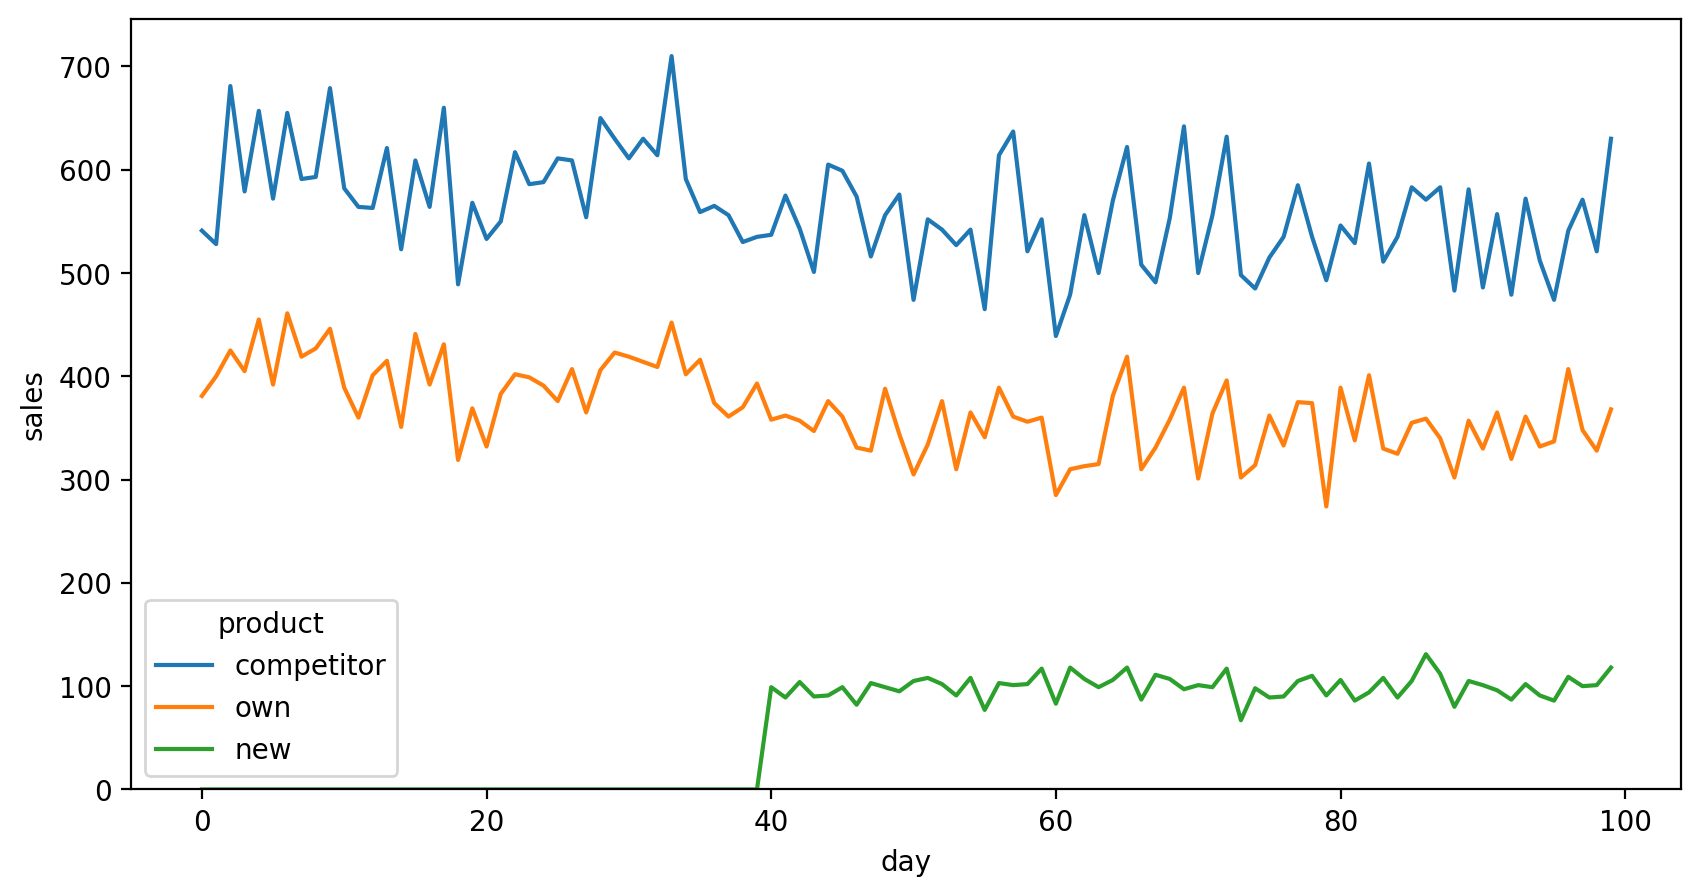

In [16]:
ax = MVITS.plot_data(data)
ax.set(ylabel="sales");

Let's take a look at the relationships between the new product sales and the own and competitor sales. In comparison to the first scenario, we now see positive correlations. This might be a bit of an advanced warning sign because it runs counter to the assumption of the model - when new sales are higher the own and competitor sales are lower.

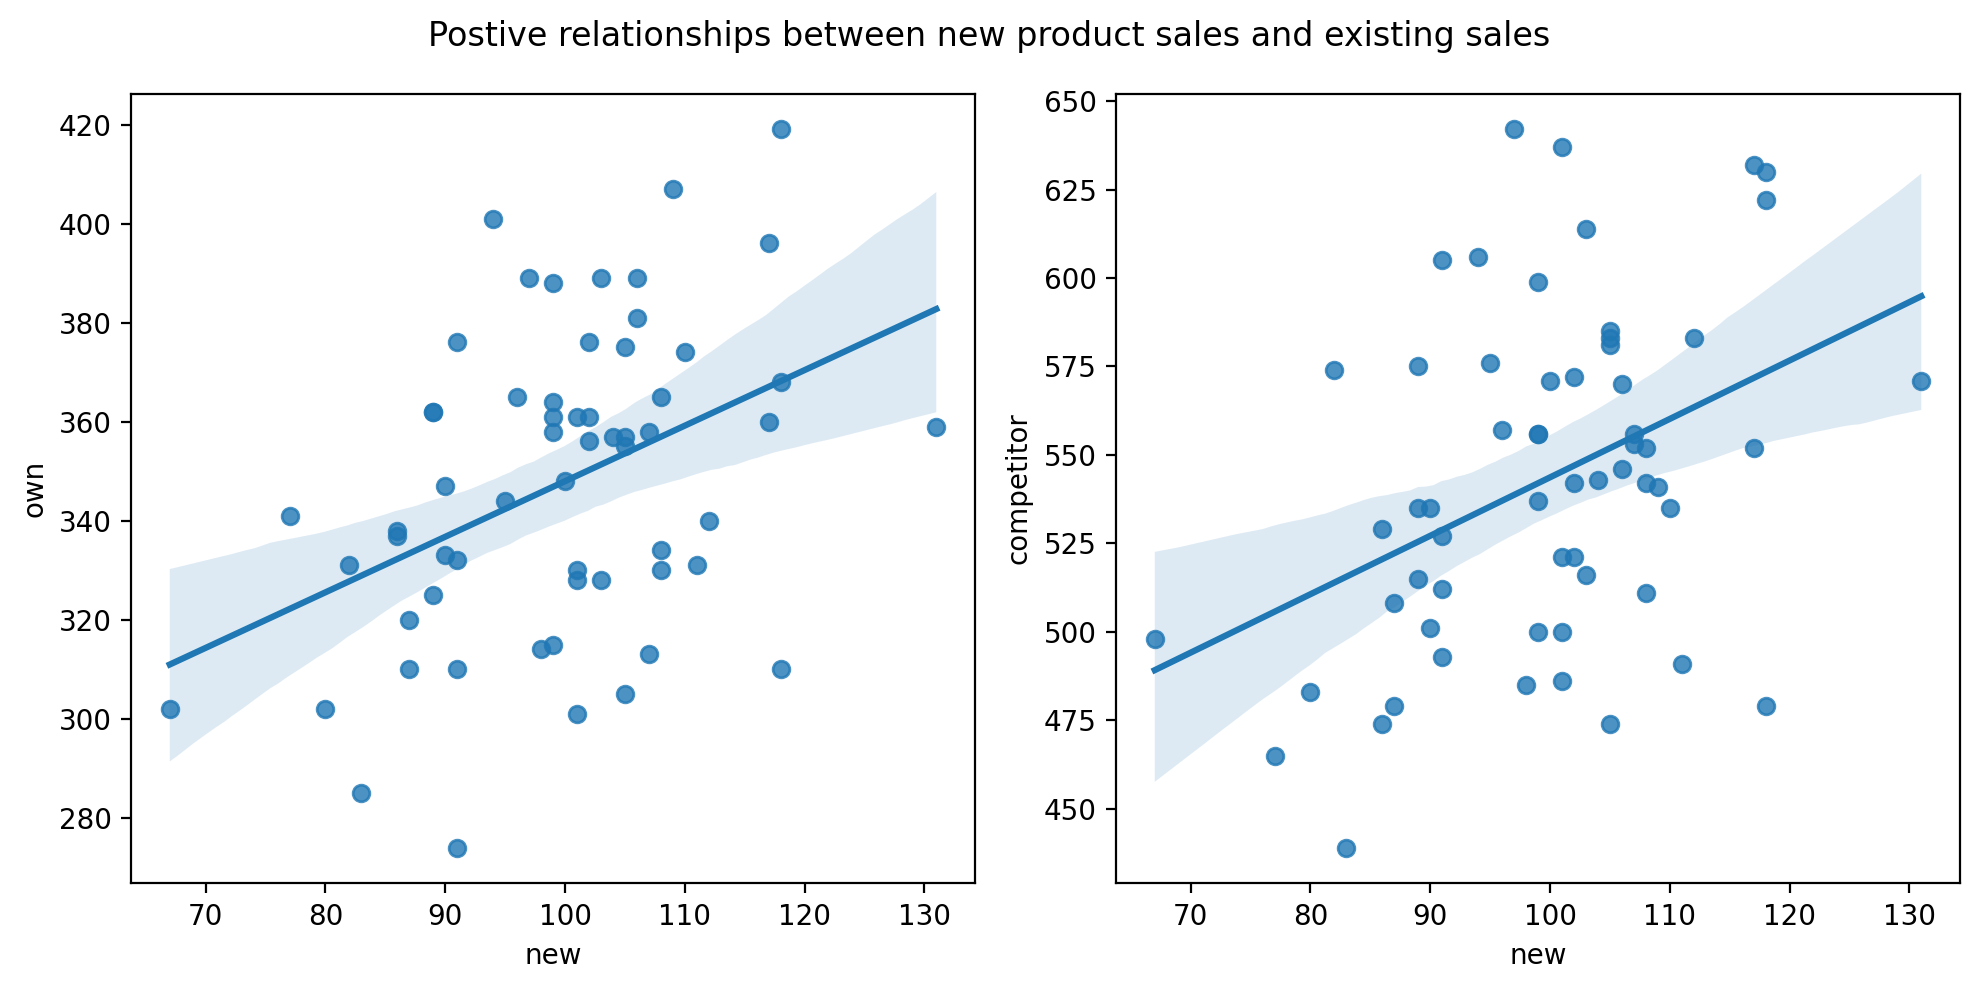

In [17]:
fig, ax = plt.subplots(1, 2)
sns.regplot(data=data.query("pre == False"), x="new", y="own", ax=ax[0])
sns.regplot(data=data.query("pre == False"), x="new", y="competitor", ax=ax[1])
plt.suptitle("Postive relationships between new product sales and existing sales")
plt.tight_layout()

Why does is this happening? For any given point in time, because own and competitor sales are drawn from a multinomial distribution, we would expect the empirical sales counts to reflect the (unchanging in this example) latent market shares. However, the high variability in total sales induces a positive correlation in sales counts. On days where there are more total sales, there tends to be more new product sales and more own and competitor sales.

As we said, this is a forewarning of potential problems. Let's see how this pans out by applying the MVITS model to the data.

In [18]:
result = MVITS(
    data,
    treatment_time=scenario2["treatment_time"],
    background_sales=["competitor", "own"],
    innovation_sales="new",
    rng=rng,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, background_product_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y]


Output()

Sampling: [y]


Output()

So how does the model do? Our simulated data was set so that new product sales were 50% incremental, and necessarily 50% cannibalistic under the saturated market assumption. The plot of our estimated causal impact shows that we are veering away from this 50/50, with more sales of the new product being attributed as having come from own sales.

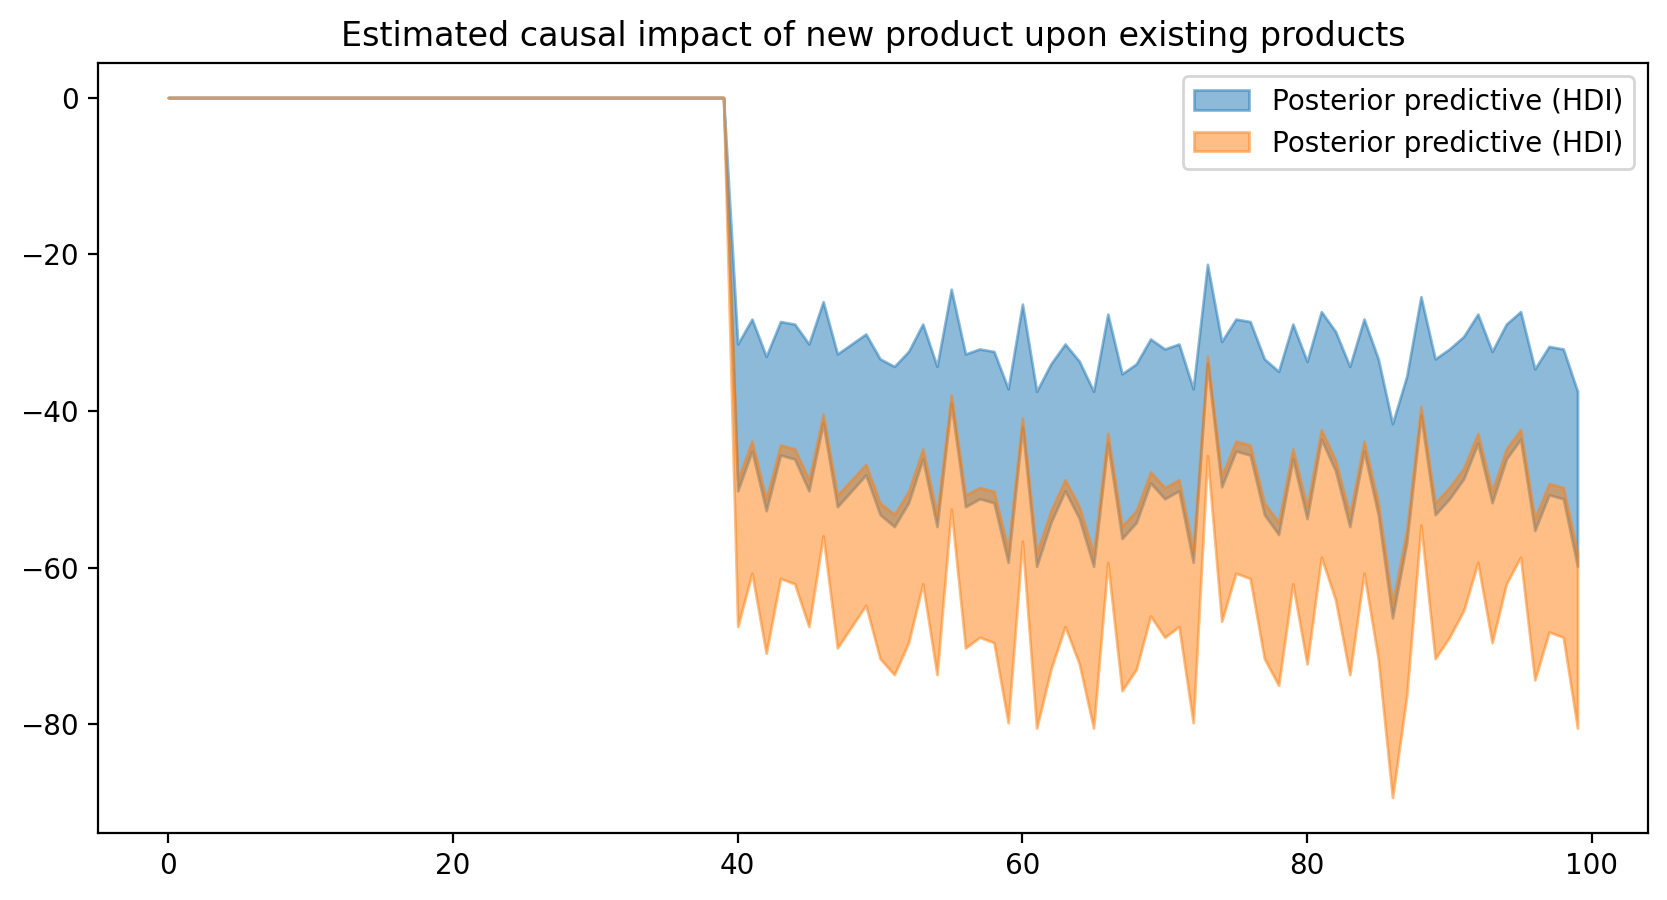

In [19]:
result.plot_causal_impact()

Examining the $\beta$ weights confirms this is the case. It is not terrible, but the model is estimating approximately 58% cannibalisation and only 42% incrementality.

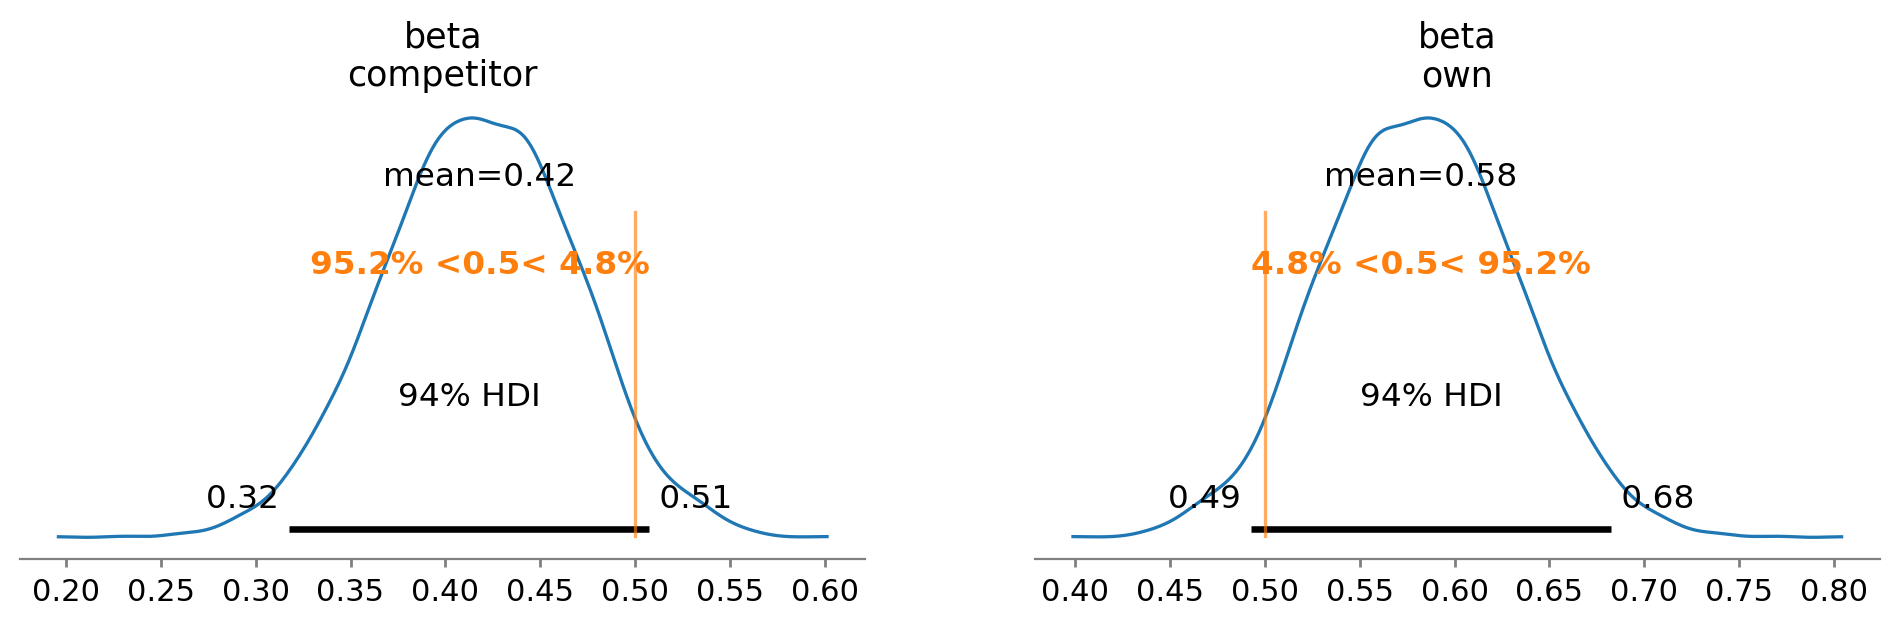

In [20]:
az.plot_posterior(
    result.idata, var_names=["beta"], ref_val=0.5, textsize=11, figsize=(12, 3)
);

You can experiment yourself to confirm, but as the level of variabilty in total sales increases, we get more of a positive correlation between the new sales and the own and competitor sales, and more biased estimates of incrementality.

Even in this highly simplified example with simulated data, we can see that the MVITS model has its limitations in being able to accurately identify incrementality.